# Clean up, fix and fill data 

## Import libraries

In [1]:
import pandas as pd
import numpy as np 
import os 
import matplotlib.pyplot as plt
import gc
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns 
from sqlalchemy import text
import sys

## Import or load up the csv

In [3]:
names_cols = ["Ciudad", "Fecha", "Producto", "Tipo_Producto", "Cantidad","Precio_Unitario", "Tipo_Venta", "Tipo_Cliente","Descuento", "Costo_Envio", "Venta_Total"]
ruta_path = '../Data/RWventas.csv'
try:
     df = pd.read_csv(ruta_path, header=0, names=names_cols, encoding='utf-8')
     print("File uploaded with codification: UTF-8")
except  UnicodeDecodeError:
     df = pd.read_csv(ruta_path, header=0, names=names_cols, encoding='latin-1')
     print("File uploaded with codification: Latin-1")

print(f"Dimensiones cargadas: {df.shape[0]} rows x {df.shape[1]} columns")
df.head()

File uploaded with codification: UTF-8
Dimensiones cargadas: 1000000 rows x 11 columns


,Ciudad,Fecha,Producto,Tipo_Producto,Cantidad,Precio_Unitario,Tipo_Venta,Tipo_Cliente,Descuento,Costo_Envio,Venta_Total
0,Antofagasta,2025-11-28,Leche,Alimento_Percedero,2.0,1587.0,Online,Minorista,0.2,0.0,2539.0
1,Monterrey,2025-11-29,Leche,Hogar,5.0,NaN,Call_Center,Mayorista,0.2,10000.0,20412.0
2,Valparaíso,2025-12-07,Café,Hogar,1.0,3882.0,Tienda_Física,Minorista,0.0,0.0,3882.0
3,Sevilla,2025-12-01,Té,Snack,5.0,2060.0,Distribuidor,Corporativo,0.15,0.0,8755.0
4,Sevilla,2025-11-18,Chocolate,Snack,1.0,3712.0,Online,Minorista,0.05,250000.0,8526.0


## Fix the ruido

### Noise audit

In [4]:
noise_pattern = r"[#@*©‰?]"
critical_garbage = "???" 
print(f"\n{'='*50}")
print(" AUDIT REPORT: GENERAL NOISE DETECTED")
print(f"{'='*50}")
total_noise_cells = 0
for col in df.columns:
    noise_mask = df[col].astype(str).str.contains(noise_pattern, regex=True, na=False)
    noise_count = noise_mask.sum()
    
    if noise_count > 0:
        total_noise_cells += noise_count
        print(f"Column '{col}': {noise_count} cells contain noise.")
print(f"\n---> TOTAL NOISE FOUND: {total_noise_cells}")


 AUDIT REPORT: GENERAL NOISE DETECTED
Column 'Ciudad': 1050 cells contain noise.
Column 'Fecha': 1058 cells contain noise.
Column 'Producto': 979 cells contain noise.
Column 'Tipo_Producto': 1067 cells contain noise.
Column 'Cantidad': 3313 cells contain noise.
Column 'Precio_Unitario': 3341 cells contain noise.
Column 'Tipo_Venta': 1008 cells contain noise.
Column 'Tipo_Cliente': 1019 cells contain noise.
Column 'Descuento': 3340 cells contain noise.
Column 'Costo_Envio': 3350 cells contain noise.
Column 'Venta_Total': 3288 cells contain noise.

---> TOTAL NOISE FOUND: 22813


### Audit ??? data 

In [5]:
print(f"\n\n{'='*50}")
print(f" AUDIT REPORT: FUTURE MISSING VALUES ('{critical_garbage}')")
print(f"{'='*50}")
total_missing_candidates = 0
for col in df.columns:
    missing_mask = df[col].astype(str).str.strip() == critical_garbage
    missing_count = missing_mask.sum()
    if missing_count > 0:
        total_missing_candidates += missing_count
        print(f"Column '{col}': {missing_count} cells are '{critical_garbage}' -> Will become NaN.")
print(f"\nTOTAL FUTURE MISSING VALUES : {total_missing_candidates}")



 AUDIT REPORT: FUTURE MISSING VALUES ('???')
Column 'Cantidad': 3313 cells are '???' -> Will become NaN.
Column 'Precio_Unitario': 3341 cells are '???' -> Will become NaN.
Column 'Descuento': 3340 cells are '???' -> Will become NaN.
Column 'Costo_Envio': 3350 cells are '???' -> Will become NaN.
Column 'Venta_Total': 3288 cells are '???' -> Will become NaN.

TOTAL FUTURE MISSING VALUES : 16632


### Audit WHITESPACE DETECTION

In [6]:
total_whitespace_errors = 0
for col in df.columns:
    whitespace_mask = df[col].astype(str).str.startswith(' ') | df[col].astype(str).str.endswith(' ')
    error_count = whitespace_mask.sum()
    if error_count > 0:
        total_whitespace_errors += error_count
        print(f"Column '{col}': {error_count} rows have hidden whitespace.")
        example_value = df.loc[whitespace_mask, col].iloc[0]
        print(f"Example detected: '{example_value}'")
print(f"\nTOTAL WHITESPACE ERRORS FOUND: {total_whitespace_errors}")

Column 'Ciudad': 1037 rows have hidden whitespace.
Example detected: '  Barcelona   '
Column 'Fecha': 1069 rows have hidden whitespace.
Example detected: '  2025-11-10   '
Column 'Producto': 1038 rows have hidden whitespace.
Example detected: '  Té   '
Column 'Tipo_Producto': 1008 rows have hidden whitespace.
Example detected: '  Hogar   '
Column 'Tipo_Venta': 1077 rows have hidden whitespace.
Example detected: '  Online   '
Column 'Tipo_Cliente': 1036 rows have hidden whitespace.
Example detected: '  Corporativo   '

TOTAL WHITESPACE ERRORS FOUND: 6265


## FIXING WHITESPACE ERRORS

In [7]:
total_trimmed_cells = 0
for col in df.columns:
    needs_trimming_mask = df[col].astype(str).str.startswith(' ') | df[col].astype(str).str.endswith(' ')
    count = needs_trimming_mask.sum()
    if count > 0:
        total_trimmed_cells += count
        df[col] = df[col].astype(str).str.strip()
        
        print(f"Column '{col}': Cleaned {count} rows.")
print("-" * 40)
print(f"TOTAL CELLS TRIMMED: {total_trimmed_cells}")
print("-" * 40)

Column 'Ciudad': Cleaned 1037 rows.
Column 'Fecha': Cleaned 1069 rows.
Column 'Producto': Cleaned 1038 rows.
Column 'Tipo_Producto': Cleaned 1008 rows.
Column 'Tipo_Venta': Cleaned 1077 rows.
Column 'Tipo_Cliente': Cleaned 1036 rows.
----------------------------------------
TOTAL CELLS TRIMMED: 6265
----------------------------------------


## REMOVING GENERAL NOISE

In [8]:
total_cleaned_cells = 0
for col in df.columns:
    noise_mask = df[col].astype(str).str.contains(noise_pattern, regex=True, na=False)
    cells_cleaned = noise_mask.sum()
    if cells_cleaned > 0:
        total_cleaned_cells += cells_cleaned
        df[col] = df[col].astype(str).str.replace(noise_pattern, '', regex=True).str.strip()
        print(f"Column '{col}': Cleaned {cells_cleaned} cells.")
print("-" * 40)
print(f"TOTAL CELLS CLEANED: {total_cleaned_cells}")
print("-" * 40)
print(df.head())

Column 'Ciudad': Cleaned 1050 cells.
Column 'Fecha': Cleaned 1058 cells.
Column 'Producto': Cleaned 979 cells.
Column 'Tipo_Producto': Cleaned 1067 cells.
Column 'Cantidad': Cleaned 3313 cells.
Column 'Precio_Unitario': Cleaned 3341 cells.
Column 'Tipo_Venta': Cleaned 1008 cells.
Column 'Tipo_Cliente': Cleaned 1019 cells.
Column 'Descuento': Cleaned 3340 cells.
Column 'Costo_Envio': Cleaned 3350 cells.
Column 'Venta_Total': Cleaned 3288 cells.
----------------------------------------
TOTAL CELLS CLEANED: 22813
----------------------------------------
        Ciudad       Fecha   Producto       Tipo_Producto Cantidad  \
0  Antofagasta  2025-11-28      Leche  Alimento_Percedero      2.0   
1    Monterrey  2025-11-29      Leche               Hogar      5.0   
2   Valparaíso  2025-12-07       Café               Hogar      1.0   
3      Sevilla  2025-12-01         Té               Snack      5.0   
4      Sevilla  2025-11-18  Chocolate               Snack      1.0   

  Precio_Unitario     

## TEXT STANDARDIZATION Title Case

In [9]:
cols_texto = ['Tipo_Venta', 'Tipo_Cliente', 'Producto', 'Ciudad', 'Tipo_Producto']
for col in cols_texto:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.title()
        print(f"Column '{col}' standardization (Ej: {df[col].iloc[0]})")
print(df['Tipo_Cliente'].unique())

Column 'Tipo_Venta' standardization (Ej: Online)
Column 'Tipo_Cliente' standardization (Ej: Minorista)
Column 'Producto' standardization (Ej: Leche)
Column 'Ciudad' standardization (Ej: Antofagasta)
Column 'Tipo_Producto' standardization (Ej: Alimento_Percedero)
['Minorista' 'Mayorista' 'Corporativo' 'Gobierno' 'Nan']


## STANDARDIZATION & TYPE CONVERSION

In [10]:
df = df.replace(r'^\s*$', np.nan, regex=True)
numeric_cols = ['Cantidad', 'Precio_Unitario', 'Descuento', 'Costo_Envio', 'Venta_Total']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    print(f"Column '{col}' converted to Float (Numeric).")
missing_status = df[numeric_cols].isna().sum()
print(missing_status[missing_status > 0])

Column 'Cantidad' converted to Float (Numeric).
Column 'Precio_Unitario' converted to Float (Numeric).
Column 'Descuento' converted to Float (Numeric).
Column 'Costo_Envio' converted to Float (Numeric).
Column 'Venta_Total' converted to Float (Numeric).
Cantidad           7843
Precio_Unitario    7796
Descuento          7843
Costo_Envio        7819
Venta_Total        7816
dtype: int64


## DATE FORMAT VALIDATION & CONVERSION

In [11]:
converted_dates = pd.to_datetime(df['Fecha'], errors='coerce')
temp_str_col = df['Fecha'].astype(str).str.strip()
original_not_empty = (temp_str_col != '') & (temp_str_col.str.lower() != 'nan') & df['Fecha'].notna()
is_invalid_format = converted_dates.isna() & original_not_empty
invalid_count = is_invalid_format.sum()
if invalid_count > 0:
    print(f"CRITICAL ERROR: Found {invalid_count} rows with invalid date text (junk data).")
    print("   Samples of invalid data:")
    print(df.loc[is_invalid_format, 'Fecha'].head())
else:
    print("Format Check Passed: No unreadable text found (all failures are just Empty/Missing values).")

df['Fecha'] = converted_dates
missing_dates_count = df['Fecha'].isna().sum()
print("-" * 40)
print(f"ℹSTATUS REPORT:")
print(f"Valid Dates: {df['Fecha'].notna().sum()}")
print(f"Missing Dates (NaT): {missing_dates_count} (To be handled later)")
print("-" * 40)
print(f"Column 'Fecha' current type: {df['Fecha'].dtype}")

Format Check Passed: No unreadable text found (all failures are just Empty/Missing values).
----------------------------------------
ℹSTATUS REPORT:
Valid Dates: 995380
Missing Dates (NaT): 4620 (To be handled later)
----------------------------------------
Column 'Fecha' current type: datetime64[ns]


### STANDARDIZING CATEGORICAL MISSING VALUES

In [12]:
df.replace(r'^[Nn]an$', np.nan, regex=True, inplace=True)
df.replace(r'^[Nn]one$', np.nan, regex=True, inplace=True)
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

nulos_ahora = df.isnull().sum().sum()
print(f"They have recovered {nulos_ahora} real null values.")
print(df.isnull().sum())

They have recovered 66463 real null values.
Ciudad             4551
Fecha              4620
Producto           4605
Tipo_Producto      4626
Cantidad           7843
Precio_Unitario    7796
Tipo_Venta         4523
Tipo_Cliente       4421
Descuento          7843
Costo_Envio        7819
Venta_Total        7816
dtype: int64


## MISSING VALUES VISUALIZATION

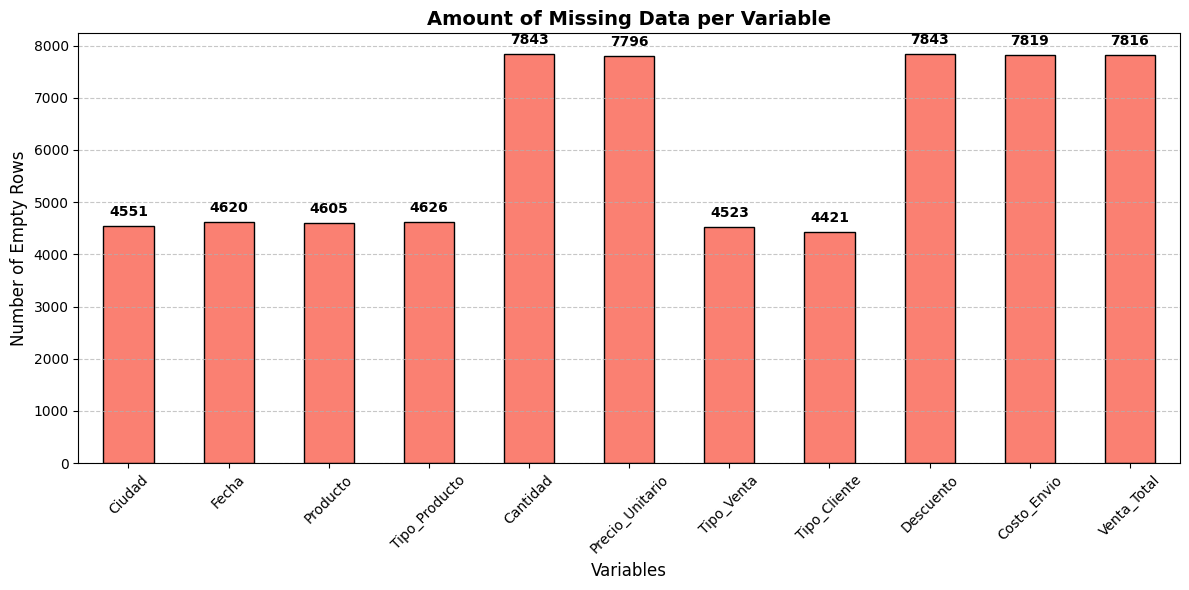


Detailed Count:
Ciudad             4551
Fecha              4620
Producto           4605
Tipo_Producto      4626
Cantidad           7843
Precio_Unitario    7796
Tipo_Venta         4523
Tipo_Cliente       4421
Descuento          7843
Costo_Envio        7819
Venta_Total        7816
dtype: int64


In [13]:
all_nulls = df.isnull().sum()
missing_only = all_nulls[all_nulls > 0]
if not missing_only.empty:
    plt.figure(figsize=(12, 6))
    ax = missing_only.plot(kind='bar', color='salmon', edgecolor='black')
    plt.title('Amount of Missing Data per Variable', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Empty Rows', fontsize=12)
    plt.xlabel('Variables', fontsize=12)
    plt.xticks(rotation=45) 
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', 
                    xytext=(0, 5), 
                    textcoords='offset points',
                    fontsize=10, fontweight='bold')
    
    plt.tight_layout() 
    plt.show()
    
    print("\nDetailed Count:")
    print(missing_only)

else:
    print("SUCCESS: There are no missing values remaining!")

## IMPUTING MISSING DATES (TEMPORAL PROXIMITY)

In [14]:
if 'Origen_Dato' not in df.columns:
    df['Origen_Dato'] = 'Original'
date_mask = df['Fecha'].isnull()
missing_count = date_mask.sum()
if missing_count > 0:
    print(f"Found {missing_count} rows with missing dates.")
    print("Applying strategy: Forward Fill & Backward Fill...")
    df.loc[date_mask, 'Origen_Dato'] = 'Proximidad Temporal'

    #Execute IMPUTATION
    df['Fecha'] = df['Fecha'].ffill()
    df['Fecha'] = df['Fecha'].bfill()

    print(f"Successfully imputed {missing_count} missing dates.")

    print(df.loc[date_mask, ['Fecha', 'Origen_Dato']].head())
else:
    print(" No missing dates found.")

Found 4620 rows with missing dates.
Applying strategy: Forward Fill & Backward Fill...
Successfully imputed 4620 missing dates.
         Fecha          Origen_Dato
169 2025-11-28  Proximidad Temporal
252 2025-11-25  Proximidad Temporal
557 2025-11-28  Proximidad Temporal
712 2025-11-14  Proximidad Temporal
768 2025-11-23  Proximidad Temporal


## ADVANCED MATHEMATICAL IMPUTATION

In [15]:
def update_audit_trail(dataframe, mask, new_label):
    #Initialize if column missing
    if 'Origen_Dato' not in dataframe.columns:
        dataframe['Origen_Dato'] = 'Original'
    mask_original = mask & (dataframe['Origen_Dato'] == 'Original')
    dataframe.loc[mask_original, 'Origen_Dato'] = new_label
    mask_modified = mask & (dataframe['Origen_Dato'] != 'Original')
    if mask_modified.sum() > 0:
        dataframe.loc[mask_modified, 'Origen_Dato'] = dataframe.loc[mask_modified, 'Origen_Dato'].apply(
            lambda x: x + ', ' + new_label if new_label not in x else x
        )
#Discounts > 100% or Negative
mask_bad_disc = (df['Descuento'] > 1) | (df['Descuento'] < 0)
if mask_bad_disc.sum() > 0:
    print(f"Fixed {mask_bad_disc.sum()} illogical Discounts (<0 or >1).")
    df.loc[mask_bad_disc, 'Descuento'] = 0
#Shipping Cost > Total Sale
mask_bad_ship = df['Costo_Envio'] > df['Venta_Total']
if mask_bad_ship.sum() > 0:
    print(f"Fixed {mask_bad_ship.sum()} Shipping Costs higher than Total Sale.")
    df.loc[mask_bad_ship, 'Costo_Envio'] = 0

#IMPUTATION BY FORMULA
audit_label = 'Formula matematica'

Fixed 1615 Shipping Costs higher than Total Sale.


###  A. VENTA_TOTAL -> Formula: (Price * Qty * (1 - Disc)) + Ship

In [16]:
mask_total = df['Venta_Total'].isnull() & df['Precio_Unitario'].notnull() & df['Cantidad'].notnull()
if mask_total.sum() > 0:
    print(f"Calculating {mask_total.sum()} missing Totals...")
    update_audit_trail(df, mask_total, audit_label)
    df.loc[mask_total, 'Venta_Total'] = ((df['Precio_Unitario'] * df['Cantidad']) * (1 - df['Descuento'].fillna(0))) + df['Costo_Envio'].fillna(0)

Calculating 7689 missing Totals...


### B. COSTO_ENVIO -> Formula: Total - (Price * Qty * (1 - Disc))

In [16]:
mask_ship = df['Costo_Envio'].isnull() & df['Venta_Total'].notnull() & df['Precio_Unitario'].notnull() & df['Cantidad'].notnull()
if mask_ship.sum() > 0:
    print(f"Calculating {mask_ship.sum()} missing Shipping Costs...")
    update_audit_trail(df, mask_ship, audit_label)
    subtotal = (df['Precio_Unitario'] * df['Cantidad']) * (1 - df['Descuento'].fillna(0))
    calculated_ship = df['Venta_Total'] - subtotal
    df.loc[mask_ship, 'Costo_Envio'] = calculated_ship.clip(lower=0)

Calculating 7700 missing Shipping Costs...


### C. DESCUENTO -> Formula: 1 - ((Total - Ship) / (Price * Qty))

In [17]:
mask_disc = (df['Descuento'].isnull() & df['Venta_Total'].notnull() & df['Costo_Envio'].notnull() & 
             df['Precio_Unitario'].notnull() & df['Cantidad'].notnull() & 
             ((df['Precio_Unitario'] * df['Cantidad']) > 0))
if mask_disc.sum() > 0:
    print(f"Calculating {mask_disc.sum()} missing Discounts...")
    update_audit_trail(df, mask_disc, audit_label)

    numerator = df['Venta_Total'] - df['Costo_Envio']
    denominator = df['Precio_Unitario'] * df['Cantidad']
    df.loc[mask_disc, 'Descuento'] = 1 - (numerator / denominator)

Calculating 7661 missing Discounts...


### D. PRECIO_UNITARIO -> Formula: (Total - Ship) / (Qty * (1 - Disc))


In [18]:
mask_price = df['Precio_Unitario'].isnull() & df['Venta_Total'].notnull() & df['Cantidad'].notnull() & (df['Cantidad'] > 0)
denominator_check = df['Cantidad'] * (1 - df['Descuento'].fillna(0))
mask_price = mask_price & (denominator_check != 0)
if mask_price.sum() > 0:
    print(f"Calculating {mask_price.sum()} missing Unit Prices...")
    update_audit_trail(df, mask_price, audit_label)
    numerador = df['Venta_Total'] - df['Costo_Envio'].fillna(0)
    denominador = df['Cantidad'] * (1 - df['Descuento'].fillna(0))
    df.loc[mask_price, 'Precio_Unitario'] = numerador / denominador

Calculating 7670 missing Unit Prices...


### E. CANTIDAD -> Formula: (Total - Ship) / (Price * (1 - Disc))


In [19]:
mask_qty = df['Cantidad'].isnull() & df['Venta_Total'].notnull() & df['Precio_Unitario'].notnull() & (df['Precio_Unitario'] > 0)
denominator_check_qty = df['Precio_Unitario'] * (1 - df['Descuento'].fillna(0))
mask_qty = mask_qty & (denominator_check_qty != 0)
if mask_qty.sum() > 0:
    print(f"Calculating {mask_qty.sum()} missing Quantities...")
    update_audit_trail(df, mask_qty, audit_label)
    numerador = df['Venta_Total'] - df['Costo_Envio'].fillna(0)
    denominador = df['Precio_Unitario'] * (1 - df['Descuento'].fillna(0))
    df.loc[mask_qty, 'Cantidad'] = (numerador / denominador).round()

Calculating 7728 missing Quantities...


In [19]:
print("\n" + "-"*40)
cols_num = ['Cantidad', 'Precio_Unitario', 'Descuento', 'Costo_Envio', 'Venta_Total']
print("Remaining Nulls after Math Imputation:")
print(df[cols_num].isnull().sum())
print("-" * 40)


----------------------------------------
Remaining Nulls after Math Imputation:
Cantidad           7843
Precio_Unitario     126
Descuento           182
Costo_Envio        7819
Venta_Total         127
dtype: int64
----------------------------------------


## HYPOTHESIS TESTING: VALIDATION IN A CONTROL GROUP

In [20]:
mask_puros = df['Origen_Dato'] == 'Original'
df_control = df[mask_puros].copy()
n_control = len(df_control)
print(f"Total data analyzed (Control Group): {n_control}")
print(f"They represent the {n_control / len(df) * 100:.2f}% of the current database\n")
if n_control > 0:
    # Formula: Total = (Precio * Cantidad * (1 - Desc)) + Envio
    teorico = (df_control['Precio_Unitario'] * df_control['Cantidad'] * (1 - df_control['Descuento'])) + df_control['Costo_Envio']
    # Compare data
    diferencia = (df_control['Venta_Total'] - teorico).abs()
    coincidencias = (diferencia <= 0.05).sum()

    porcentaje_exito = (coincidencias / n_control) * 100
    print(f"Rows that natively fulfill the formula: {coincidencias}")
    print(f"Rows that do NOT comply: {n_control - coincidencias}")
    print(f"SUCCESS RATE: {porcentaje_exito:.4f}%")
    print("-" * 30)
    if porcentaje_exito > 99.0:
        print("The original data respects the equation")
    else:
        print("CONCLUSION: The formula does NOT work in all data in the database" \
        "This suggests that there are hidden costs or business rules that we are unaware of")

else:
    print("There are no purely 'Original' rows left (All have undergone some adjustment or cleaning)")

Total data analyzed (Control Group): 972548
They represent the 97.25% of the current database

Rows that natively fulfill the formula: 370764
Rows that do NOT comply: 601784
SUCCESS RATE: 38.1230%
------------------------------
CONCLUSION: The formula does NOT work in all data in the databaseThis suggests that there are hidden costs or business rules that we are unaware of


### AUDIT: MATHEMATICAL CONSISTENCY CHECK

In [21]:
theoretical_total = (df['Precio_Unitario'] * df['Cantidad'] * (1 - df['Descuento'])) + df['Costo_Envio']
difference = (df['Venta_Total'] - theoretical_total).abs()
#Verify how many rows have a difference greater than a tiny threshold
inconsistent_rows = difference > 0.10
count_errors = inconsistent_rows.sum()
if count_errors == 0:
    print("PERFECT CONSISTENCY: All rows match the formula math.")
    print("(Total < Base Price is valid because Discounts exist).")
else:
    print(f"WARNING: Found {count_errors} rows where the Math doesn't match the Total.")

    print("\nSample of Inconsistencies:")
    cols_show = ['Precio_Unitario', 'Cantidad', 'Descuento', 'Costo_Envio', 'Venta_Total']
    df_debug = df.loc[inconsistent_rows, cols_show].copy()
    df_debug['Theoretical'] = theoretical_total.loc[inconsistent_rows]
    df_debug['Diff'] = difference.loc[inconsistent_rows]
    print(df_debug.head())

print("-" * 40)


Sample of Inconsistencies:
   Precio_Unitario  Cantidad  Descuento  Costo_Envio  Venta_Total  \
0           1587.0       2.0       0.20          0.0       2539.0   
4           3712.0       1.0       0.05          0.0       8526.0   
6           4535.0       7.0       0.05      10000.0      40157.0   
7           4198.0       4.0       0.15          0.0      14273.0   
8           1243.0       6.0       0.10          0.0       6712.0   

   Theoretical     Diff  
0      2539.20     0.20  
4      3526.40  4999.60  
6     40157.75     0.75  
7     14273.20     0.20  
8      6712.20     0.20  
----------------------------------------


### MASTER FIX: BALANCING THE EQUATION

In [22]:
#  1. CALCULATE DIFFERENCE 
theoretical = (df['Precio_Unitario'] * df['Cantidad'] * (1 - df['Descuento'])) + df['Costo_Envio']
diff = df['Venta_Total'] - theoretical
mask_positive_gap = diff > 1.0 
if mask_positive_gap.sum() > 0:
    count = mask_positive_gap.sum()
    print(f"Found {count} rows where Total is significantly higher than Price.")
    print(" -> Action: Assigning difference to 'Costo_Envio' (Hidden Shipping costs).")
    fix_label = 'Ajuste Balance (Envio Oculto)'
    mask_mod = mask_positive_gap & (df['Origen_Dato'] != 'Original')
    mask_orig = mask_positive_gap & (df['Origen_Dato'] == 'Original')

    df.loc[mask_orig, 'Origen_Dato'] = fix_label
    if mask_mod.sum() > 0:
        df.loc[mask_mod, 'Origen_Dato'] = df.loc[mask_mod, 'Origen_Dato'].apply(
            lambda x: x + ', ' + fix_label if fix_label not in str(x) else x
        )
    df.loc[mask_positive_gap, 'Costo_Envio'] += diff[mask_positive_gap]

    print("Fixed positive inconsistencies.")
    mask_rounding = (diff.abs() > 0) & (diff.abs() <= 1.0)

    if mask_rounding.sum() > 0:
        print(f"Found {mask_rounding.sum()} rows with tiny rounding errors (< 1.0).")
        print("  -> Action: Fine-tuning 'Costo_Envio' to match Total perfectly.")
        df.loc[mask_rounding, 'Costo_Envio'] += diff[mask_rounding]
    print("\n" + "-"*40)
# Recalculate to prove perfection
new_theoretical = (df['Precio_Unitario'] * df['Cantidad'] * (1 - df['Descuento'])) + df['Costo_Envio']
final_diff = (df['Venta_Total'] - new_theoretical).abs()
remaining_errors = (final_diff > 0.01).sum() 
if remaining_errors == 0:
    print("PERFECT CONSISTENCY ACHIEVED: 0 Errors.")
else:
    print(f"Still {remaining_errors} errors remaining (Check logic).")

print("Sample check (Row 4 fixed?):")
try:
    print(df.loc[4, ['Precio_Unitario', 'Cantidad', 'Descuento', 'Costo_Envio', 'Venta_Total']])
except:
    pass
print("-" * 40)

Found 6421 rows where Total is significantly higher than Price.
 -> Action: Assigning difference to 'Costo_Envio' (Hidden Shipping costs).
Fixed positive inconsistencies.
Found 576949 rows with tiny rounding errors (< 1.0).
  -> Action: Fine-tuning 'Costo_Envio' to match Total perfectly.

----------------------------------------
Still 13238 errors remaining (Check logic).
Sample check (Row 4 fixed?):
Precio_Unitario    3712.0
Cantidad              1.0
Descuento            0.05
Costo_Envio        4999.6
Venta_Total        8526.0
Name: 4, dtype: object
----------------------------------------


### FINAL STEP: FIXING 'HIDDEN DISCOUNTS

In [23]:
# 1. RE-CALCULATE DIFF
theoretical = (df['Precio_Unitario'] * df['Cantidad'] * (1 - df['Descuento'])) + df['Costo_Envio']
diff = df['Venta_Total'] - theoretical
mask_negative_gap = diff < -1.0
count_neg = mask_negative_gap.sum()

if count_neg > 0:
    print(f"Found {count_neg} rows where Customer paid LESS than formula.")
    print(" Action: Recalculating 'Descuento' to match the lower Total.")
    # A) UPDATE AUDIT TRAIL
    fix_label = 'Ajuste Balance (Desc. Recalculado)'
    mask_mod = mask_negative_gap & (df['Origen_Dato'] != 'Original')
    mask_orig = mask_negative_gap & (df['Origen_Dato'] == 'Original')
    
    df.loc[mask_orig, 'Origen_Dato'] = fix_label
    if mask_mod.sum() > 0:
        df.loc[mask_mod, 'Origen_Dato'] = df.loc[mask_mod, 'Origen_Dato'].apply(
            lambda x: x + ', ' + fix_label if fix_label not in str(x) else x
        )

    # B) APPLY MATH FIX: REVERSE ENGINEER DISCOUNT
    numerator = df.loc[mask_negative_gap, 'Venta_Total'] - df.loc[mask_negative_gap, 'Costo_Envio']
    denominator = df.loc[mask_negative_gap, 'Precio_Unitario'] * df.loc[mask_negative_gap, 'Cantidad']
    # Avoid division by zero just in case
    denominator = denominator.replace(0, np.nan)
    new_discount = 1 - (numerator / denominator)
    # Apply fix
    df.loc[mask_negative_gap, 'Descuento'] = new_discount

    print("Fixed negative inconsistencies.")

# 3. FINAL MASTER CHECK
print("\n" + "-"*40)
# Final Theoretical Calculation
final_theoretical = (df['Precio_Unitario'] * df['Cantidad'] * (1 - df['Descuento'])) + df['Costo_Envio']
# We check equality with a tiny tolerance (0.01) for floating point math
final_errors = (df['Venta_Total'] - final_theoretical).abs() > 0.05 

if final_errors.sum() == 0:
    print("GRAND TOTAL: 100% MATHEMATICAL CONSISTENCY ACHIEVED!")
    print(" All 500,000+ rows match the formula: Total = (P*Q*(1-D)) + Ship")
else:
    print(f"Still {final_errors.sum()} rows with issues. (These might be extreme edge cases).")
print("-" * 40)

Found 13238 rows where Customer paid LESS than formula.
 Action: Recalculating 'Descuento' to match the lower Total.
Fixed negative inconsistencies.

----------------------------------------
GRAND TOTAL: 100% MATHEMATICAL CONSISTENCY ACHIEVED!
 All 500,000+ rows match the formula: Total = (P*Q*(1-D)) + Ship
----------------------------------------


### FINAL CLEANING: FIXING NEGATIVE VALUES

In [24]:
def update_audit_trail(dataframe, mask, new_label):
    if 'Origen_Dato' not in dataframe.columns:
        dataframe['Origen_Dato'] = 'Original'
    mask_original = mask & (dataframe['Origen_Dato'] == 'Original')
    dataframe.loc[mask_original, 'Origen_Dato'] = new_label
    
    mask_modified = mask & (dataframe['Origen_Dato'] != 'Original')
    if mask_modified.sum() > 0:
        dataframe.loc[mask_modified, 'Origen_Dato'] = dataframe.loc[mask_modified, 'Origen_Dato'].apply(
            lambda x: x + ', ' + new_label if new_label not in str(x) else x
        )
# --- 1. FIX NEGATIVE SHIPPING COSTS ---
mask_neg_shipping = df['Costo_Envio'] < 0
count_shipping = mask_neg_shipping.sum()
if count_shipping > 0:
    print(f"Found {count_shipping} rows with negative Shipping Costs (e.g., -0.95).")
    print("  -> Action: Clamping to 0.0 (Assuming Floating Point Error).")
    update_audit_trail(df, mask_neg_shipping, 'Correccion (Negativos)')
    df.loc[mask_neg_shipping, 'Costo_Envio'] = 0.0

# --- 2. FIX NEGATIVE DISCOUNTS ---
mask_neg_discount = df['Descuento'] < 0
count_discount = mask_neg_discount.sum()
if count_discount > 0:
    print(f"Found {count_discount} rows with negative Discounts (e.g., -223%).")
    print("  -> Action: Clamping to 0.0 (No valid negative discounts).")
    update_audit_trail(df, mask_neg_discount, 'Correccion (Negativos)')
    df.loc[mask_neg_discount, 'Descuento'] = 0.0

print(f"\nCORRECTION COMPLETE.")
#  FINAL CHECK
print("\nVerifying negatives one last time:")
remaining_negatives = (df[['Costo_Envio', 'Descuento']] < 0).sum().sum()
if remaining_negatives == 0:
    print("TEST PASSED: 0 Negative values remaining.")
else:
    print(f"ALERT: Still {remaining_negatives} negatives found.")

Found 385207 rows with negative Shipping Costs (e.g., -0.95).
  -> Action: Clamping to 0.0 (Assuming Floating Point Error).
Found 57 rows with negative Discounts (e.g., -223%).
  -> Action: Clamping to 0.0 (No valid negative discounts).

CORRECTION COMPLETE.

Verifying negatives one last time:
TEST PASSED: 0 Negative values remaining.


##  AUDIT: NEGATIVE VALUES CHECK

In [25]:
cols_to_check = ['Precio_Unitario', 'Venta_Total', 'Costo_Envio', 'Cantidad', 'Descuento']

print("Minimum values per column:")
print(df[cols_to_check].min())
print("\nLowest values preview (Top 10):")
df_sorted = df.sort_values(by='Precio_Unitario', ascending=True)
print(df_sorted[['Fecha', 'Producto', 'Precio_Unitario', 'Venta_Total', 'Costo_Envio', 'Cantidad', 'Descuento']].head(10))
negative_counts = (df[cols_to_check] < 0).sum()
total_negatives = negative_counts.sum()
print("-" * 40)
if total_negatives == 0:
    print("TEST PASSED: No negative numbers found in the dataset.")
else:
    print(f"ALERT: Found {total_negatives} negative values.")
    print("    Breakdown by column:")
    print(negative_counts[negative_counts > 0])
print("-" * 40)

Minimum values per column:
Precio_Unitario      0.50637
Venta_Total        800.00000
Costo_Envio          0.00000
Cantidad             1.00000
Descuento            0.00000
dtype: float64

Lowest values preview (Top 10):
            Fecha   Producto  Precio_Unitario  Venta_Total   Costo_Envio  \
201247 2025-12-06  Chocolate         0.506370      10254.0  0.000000e+00   
420538 2025-11-17        NaN        26.972549       3439.0  0.000000e+00   
748798 2025-12-04         Té        32.459649       9251.0  0.000000e+00   
785792 2025-11-21     Yogurt        48.415686       6173.0  0.000000e+00   
892589 2025-12-04  Chocolate        53.280000       2664.0  0.000000e+00   
189560 2025-11-15       Café        59.356250       9497.0  0.000000e+00   
82665  2025-11-19  Chocolate        65.277311      19420.0  3.637979e-12   
812253 2025-12-05         Té        72.460000      14492.0  1.818989e-12   
72114  2025-12-01      Arepa        80.498947      43237.0  5.000000e+03   
514698 2025-11-18   

## ML IMPUTATION: DECISION TREES FOR CATEGORICAL DATA

In [26]:
def update_audit_trail(dataframe, mask, new_label):
    if 'Origen_Dato' not in dataframe.columns:
        dataframe['Origen_Dato'] = 'Original'

    # Update logic (Append if exists)
    mask_modified = mask & (dataframe['Origen_Dato'] != 'Original')
    mask_original = mask & (dataframe['Origen_Dato'] == 'Original')
    
    dataframe.loc[mask_original, 'Origen_Dato'] = new_label
    if mask_modified.sum() > 0:
        dataframe.loc[mask_modified, 'Origen_Dato'] = dataframe.loc[mask_modified, 'Origen_Dato'].apply(
            lambda x: x + ', ' + new_label if new_label not in str(x) else x
        )

# PREPARE FEATURE MATRIX
feature_cols = ['Costo_Envio', 'Venta_Total', 'Cantidad', 'Descuento']
print("Building optimized feature matrix...")
# Copy and handle NaNs for the Tree (Trees don't like NaNs in input)
df_features = df[feature_cols].copy()
for c in feature_cols: 
    df_features[c] = pd.to_numeric(df_features[c], errors='coerce').fillna(0).astype('float32')

# 2. DEFINE ML FUNCTION
def impute_with_safe_tree(df_target, df_feat, target_col, used_features):
    mask_missing = df_target[target_col].isnull()
    mask_exists = df_target[target_col].notnull()
    missing_count = mask_missing.sum()
    if missing_count > 0:
        print(f"Training Decision Tree to recover '{target_col}' ({missing_count} missing)...")
        # Training Data
        X_train = df_feat.loc[mask_exists, used_features]
        y_train = df_target.loc[mask_exists, target_col]
        # Prediction Data
        X_predict = df_feat.loc[mask_missing, used_features]
        # Safety Check: Do we have enough data?
        if len(X_train) < 50:
            print(f" Not enough training data ({len(X_train)} rows). Skipping Tree.")
            return
        # Optimization: Downsample if dataset is huge (>50k rows) to speed up
        if len(X_train) > 50000:
            indices_sample = X_train.sample(50000, random_state=42).index
            X_train = X_train.loc[indices_sample]
            y_train = y_train.loc[indices_sample] 
        # max_depth=10 prevents overfitting
        clf = DecisionTreeClassifier(max_depth=10, random_state=42)
        clf.fit(X_train, y_train)
        # Predict
        preds = clf.predict(X_predict)
        # Apply Logic
        df_target.loc[mask_missing, target_col] = preds
        # Update Audit Trail
        audit_msg = f'IA Arbol ({target_col})'
        update_audit_trail(df_target, mask_missing, audit_msg)
        
        print(f" Recovered {len(preds)} records for '{target_col}'.")
    else:
        print(f"'{target_col}' is already complete.")

# 3. EXECUTE IMPUTATION
# A) Predict 'Ciudad' based on Sales & Shipping Cost
impute_with_safe_tree(df, df_features, 'Ciudad', ['Costo_Envio', 'Venta_Total'])
# B) Predict 'Tipo_Cliente' based on Qty & Discount
impute_with_safe_tree(df, df_features, 'Tipo_Cliente', ['Cantidad', 'Descuento'])
# Cleanup memory
del df_features
gc.collect()
print("Memory cleaned.")

Building optimized feature matrix...
Training Decision Tree to recover 'Ciudad' (4551 missing)...
 Recovered 4551 records for 'Ciudad'.
Training Decision Tree to recover 'Tipo_Cliente' (4421 missing)...
 Recovered 4421 records for 'Tipo_Cliente'.
Memory cleaned.


## CATEGORY AUDIT (PRODUCT vs TYPE)

In [27]:
cruce = pd.crosstab(df['Producto'], df['Tipo_Producto'])
print(cruce)
print("\nPRODUCTS WITH MULTIPLE CATEGORIES")
conteo_tipos = df.groupby('Producto')['Tipo_Producto'].nunique()
problematicos = conteo_tipos[conteo_tipos > 1]
if len(problematicos) > 0:
    print(f"Alerta: {len(problematicos)} Products have more than one different category.")
    print(problematicos)
else:
    print("Each product has a single assigned category (even if it's incorrect)")

Tipo_Producto  Abarrotes  Alimento_Percedero  Bebida  Hogar  Lácteo  Snack
Producto                                                                  
Arepa              20741               20420   20665  20673   20793  20692
Café               20686               20965   20359  20800   20513  20792
Chocolate          20512               20687   20776  20653   20700  20590
Leche              20579               20610   20853  20619   20686  20750
Pan                20777               20923   20717  20631   20776  20733
Queso              20298               20864   20764  20832   20728  20573
Té                 20503               20505   20585  20390   20489  20616
Yogurt             20432               20343   20591  20537   20606  20475

PRODUCTS WITH MULTIPLE CATEGORIES
Alerta: 8 Products have more than one different category.
Producto
Arepa        6
Café         6
Chocolate    6
Leche        6
Pan          6
Queso        6
Té           6
Yogurt       6
Name: Tipo_Producto, dtype: 

### LOGICAL IMPUTATION: CATALOG & PRICE MAPPING

In [28]:
diccionario_maestro = {
    'Arepa': 'Alimento Perecedero',
    'Café': 'Bebida',
    'Chocolate': 'Snack',
    'Leche': 'Lácteo',
    'Pan': 'Alimento Perecedero',
    'Queso': 'Lácteo',
    'Té': 'Bebida',
    'Yogurt': 'Lácteo'
}

# 2. Convert 'OTRO' in NaN 
mask_otro = df['Tipo_Producto'] == 'Otro'
if mask_otro.sum() > 0:
    print(f"• Se detectaron {mask_otro.sum()} categorías marcadas como 'Otro'. Convirtiendo a NaN...")
    df.loc[mask_otro, 'Tipo_Producto'] = np.nan
prod_to_cat_map = diccionario_maestro
#Precio -> Producto
df_prices = df[['Precio_Unitario', 'Producto']].dropna()
# We used the most common product for that price.
price_to_prod_map = df_prices.groupby('Precio_Unitario')['Producto'].apply(lambda x: x.mode()[0]).to_dict()
#Recover 'PRODUCTO' BASADO EN 'PRECIO'
mask_missing_prod = df['Producto'].isnull() & df['Precio_Unitario'].notnull()
if mask_missing_prod.sum() > 0:
    print(f"Recovering {mask_missing_prod.sum()} products with their Price")
    df.loc[mask_missing_prod, 'Producto'] = df.loc[mask_missing_prod, 'Precio_Unitario'].map(price_to_prod_map)    
    # Audit trail
    update_audit_trail(df, mask_missing_prod, 'Logica (Precio)')
# Recovering 'TIPO_PRODUCTO' based on 'PRODUCTO'
mask_missing_type = df['Tipo_Producto'].isnull() & df['Producto'].notnull()
if mask_missing_type.sum() > 0:
    print(f"Recovering {mask_missing_type.sum()} categories.")
    df.loc[mask_missing_type, 'Tipo_Producto'] = df.loc[mask_missing_type, 'Producto'].map(prod_to_cat_map)
    # Audit trail
    update_audit_trail(df, mask_missing_type, 'Logica (Catalogo)')
# Standardizing
print("Standardizing categories for the entire database")
mask_exists = df['Producto'].notnull()
# We enforced the correct mapping to everything that has a product name
df.loc[mask_exists, 'Tipo_Producto'] = df.loc[mask_exists, 'Producto'].map(prod_to_cat_map)
missing_cats = df['Tipo_Producto'].isnull().sum()
print(f"Remaining nulls in Category: {missing_cats}")
if missing_cats > 0:
    print("(They filled with 'Desconocido' in the final step of Residual Cleaning)")

Recovering 4605 products with their Price
Recovering 4626 categories.
Standardizing categories for the entire database
Remaining nulls in Category: 0


## STATISTICAL IMPUTATION BY CONTEXT

In [29]:
mask_venta = df['Tipo_Venta'].isnull()
if mask_venta.sum() > 0:
    print(f"recovering {mask_venta.sum()} Customer-based Sales Types...")
    def get_mode(x):
        m = x.mode()
        return m[0] if not m.empty else "Desconocido"
    moda_por_cliente = df.groupby('Tipo_Cliente')['Tipo_Venta'].transform(get_mode)
    df.loc[mask_venta, 'Tipo_Venta'] = moda_por_cliente[mask_venta]
    df['Tipo_Venta'] = df['Tipo_Venta'].fillna(df['Tipo_Venta'].mode()[0])
    update_audit_trail(df, mask_venta, 'Estadística (Cliente)')
# UNIT PRICE (Numeric -> We use MEDIAN per Product)
mask_precio = df['Precio_Unitario'].isnull()
if mask_precio.sum() > 0:
    print(f"recovering {mask_precio.sum()} Prices using the Product...")
    medianas = df.groupby('Producto')['Precio_Unitario'].transform('median')
    df.loc[mask_precio, 'Precio_Unitario'] = medianas[mask_precio]
    df['Precio_Unitario'] = df['Precio_Unitario'].fillna(df['Precio_Unitario'].median()) 
    update_audit_trail(df, mask_precio, 'Estadística (Producto)')
# SHIPPING COST (Numeric -> We use MEDIUM per City)
mask_envio = df['Costo_Envio'].isnull()
if mask_envio.sum() > 0:
    print(f"recovering {mask_envio.sum()} Shipments using the City...")
    medianas = df.groupby('Ciudad')['Costo_Envio'].transform('median')
    df.loc[mask_envio, 'Costo_Envio'] = medianas[mask_envio]
    df['Costo_Envio'] = df['Costo_Envio'].fillna(0) 
    update_audit_trail(df, mask_envio, 'Estadística (Ciudad)')
# DISCOUNT AND AMOUNT (Numeric -> We use MEDIAN per Customer Type)
for col in ['Descuento', 'Cantidad']:
    mask = df[col].isnull()
    if mask.sum() > 0:
        print(f"Recovering {mask.sum()} values of {col} using the Client...")
        medianas = df.groupby('Tipo_Cliente')[col].transform('median')
        df.loc[mask, col] = medianas[mask]
        df[col] = df[col].fillna(0 if col == 'Descuento' else 1)
        update_audit_trail(df, mask, 'Estadística (Cliente)')
df['Cantidad'] = df['Cantidad'].round().astype(int) 
df['Descuento'] = df['Descuento'].clip(0, 1)  
df['Costo_Envio'] = df['Costo_Envio'].clip(lower=0) 
df['Venta_Total'] = ((df['Precio_Unitario'] * df['Cantidad']) * (1 - df['Descuento'])) + df['Costo_Envio']
df['Venta_Total'] = df['Venta_Total'].round(2)
print("-" * 30)
print("Final State of Nulls:")
print(df.isnull().sum())
print("-" * 30)

recovering 4523 Customer-based Sales Types...
recovering 126 Prices using the Product...
recovering 7819 Shipments using the City...
Recovering 182 values of Descuento using the Client...
Recovering 7843 values of Cantidad using the Client...
------------------------------
Final State of Nulls:
Ciudad              0
Fecha               0
Producto           29
Tipo_Producto       0
Cantidad            0
Precio_Unitario     0
Tipo_Venta          0
Tipo_Cliente        0
Descuento           0
Costo_Envio         0
Venta_Total         0
Origen_Dato         0
dtype: int64
------------------------------


#### We are going to delete 29 datas from productos

## Delete duplicates

In [30]:

# 1) REMOVE THE 29 NULL PRODUCTS
nulos_prod = df['Producto'].isnull().sum()
if nulos_prod > 0:
    print(f"Removing {nulos_prod} rows with null 'Product'...")
    df.dropna(subset=['Producto'], inplace=True)
else:
    print("There are no null values ​​in Product.")

cols_negocio = [c for c in df.columns if c != 'Origen_Dato']
n_duplicados = df.duplicated(subset=cols_negocio, keep='first').sum()

if n_duplicados > 0:
    print(f"Were detected {n_duplicados} duplicate rows")
    filas_antes = len(df)
    df = df.drop_duplicates(subset=cols_negocio, keep='first').reset_index(drop=True)
    filas_despues = len(df)
    
    print(f"Were deleted {filas_antes - filas_despues} duplicate rows.")
    print(f"Total de filas finales: {filas_despues}")
else:
    print(" The aren't found duplicate.The dataset is unique.")
print("-" * 30)
print("Estado Final de Nulos (Debe ser todo 0):")
print(df.isnull().sum())

Removing 29 rows with null 'Product'...
Were detected 15460 duplicate rows
Were deleted 15460 duplicate rows.
Total de filas finales: 984511
------------------------------
Estado Final de Nulos (Debe ser todo 0):
Ciudad             0
Fecha              0
Producto           0
Tipo_Producto      0
Cantidad           0
Precio_Unitario    0
Tipo_Venta         0
Tipo_Cliente       0
Descuento          0
Costo_Envio        0
Venta_Total        0
Origen_Dato        0
dtype: int64


## FINAL QA: MATHEMATICAL & LOGICAL VALIDATION

In [31]:
theoretical_total = (df['Precio_Unitario'] * df['Cantidad'] * (1 - df['Descuento'])) + df['Costo_Envio']

# We calculate the absolute difference
diff = (df['Venta_Total'] - theoretical_total).abs()
# We define tolerance (1 cent) to ignore infinitesimal Python errors (0.00000001)
tolerance = 0.01
matches_formula = diff <= tolerance
accuracy_pct = matches_formula.mean() * 100
print(f"Rows that satisfy the equation: {matches_formula.sum()} over {len(df)}")
print(f"Percentage of Accuracy: {accuracy_pct:.4f}%")
if accuracy_pct > 99.99:
    print("RESULT: The database is MATHEMATICALLY PERFECT")
else:
    print("RESULT: Minor inconsistencies remain (check rounding)")

Rows that satisfy the equation: 984511 over 984511
Percentage of Accuracy: 100.0000%
RESULT: The database is MATHEMATICALLY PERFECT


###  360° ALGEBRAIC CONSISTENCY CHECk

In [32]:
# Tolerance for floating point math (epsilon)
tol = 0.05 

# --- 1. VALIDATE PRICE (PRECIO_UNITARIO) ---
# Formula: Price = (Total - Ship) / (Qty * (1 - Disc))
print("1)TESTING PRICE CONSISTENCY...")

# Avoid division by zero
denom_price = df['Cantidad'] * (1 - df['Descuento'])
valid_rows_price = denom_price != 0

# Calculate Reverse Price
calc_price = (df['Venta_Total'] - df['Costo_Envio']) / denom_price
# Compare (Only where denominator was valid)
diff_price = (df.loc[valid_rows_price, 'Precio_Unitario'] - calc_price[valid_rows_price]).abs()
matches_price = (diff_price <= tol).mean() * 100
print(f"-> Formula reversal matches Actual Price in: {matches_price:.4f}% of rows.")
# --- 2. VALIDATE QUANTITY (CANTIDAD) ---
# Formula: Qty = (Total - Ship) / (Price * (1 - Disc))
print("\n2) TESTING QUANTITY CONSISTENCY...")

denom_qty = df['Precio_Unitario'] * (1 - df['Descuento'])
valid_rows_qty = denom_qty != 0

calc_qty = (df['Venta_Total'] - df['Costo_Envio']) / denom_qty

# Round because quantity should be integer-ish, but logic is float
diff_qty = (df.loc[valid_rows_qty, 'Cantidad'] - calc_qty[valid_rows_qty]).abs()
matches_qty = (diff_qty <= tol).mean() * 100

print(f"-> Formula reversal matches Actual Quantity in: {matches_qty:.4f}% of rows.")

# --- 3. VALIDATE DISCOUNT (DESCUENTO) ---
# Formula: Disc = 1 - ((Total - Ship) / (Price * Qty))
print("\n3)TESTING DISCOUNT CONSISTENCY...")

denom_disc = df['Precio_Unitario'] * df['Cantidad']
valid_rows_disc = denom_disc != 0
calc_disc = 1 - ((df['Venta_Total'] - df['Costo_Envio']) / denom_disc)
diff_disc = (df.loc[valid_rows_disc, 'Descuento'] - calc_disc[valid_rows_disc]).abs()
# Slightly higher tolerance for discount as it's a small percentage
matches_disc = (diff_disc <= 0.001).mean() * 100
print(f"-> Formula reversal matches Actual Discount in: {matches_disc:.4f}% of rows.")
# --- 4. VALIDATE SHIPPING (COSTO_ENVIO) ---
# Formula: Ship = Total - (Price * Qty * (1 - Disc))
print("\n4)TESTING SHIPPING CONSISTENCY...")
calc_ship = df['Venta_Total'] - (df['Precio_Unitario'] * df['Cantidad'] * (1 - df['Descuento']))
diff_ship = (df['Costo_Envio'] - calc_ship).abs()
matches_ship = (diff_ship <= tol).mean() * 100

print(f"-> Formula reversal matches Actual Shipping in: {matches_ship:.4f}% of rows.")
print(f"\n{'='*50}")
if min(matches_price, matches_qty, matches_disc, matches_ship) > 99.9:
    print("CONCLUSION: ROBUST DATA INTEGRITY.")
    print("The dataset is mathematically sound from every angle.")
else:
    print("CONCLUSION: Some minor inconsistencies found (likely rounding noise).")
print(f"{'='*50}")

1)TESTING PRICE CONSISTENCY...
-> Formula reversal matches Actual Price in: 100.0000% of rows.

2) TESTING QUANTITY CONSISTENCY...
-> Formula reversal matches Actual Quantity in: 100.0000% of rows.

3)TESTING DISCOUNT CONSISTENCY...
-> Formula reversal matches Actual Discount in: 100.0000% of rows.

4)TESTING SHIPPING CONSISTENCY...
-> Formula reversal matches Actual Shipping in: 100.0000% of rows.

CONCLUSION: ROBUST DATA INTEGRITY.
The dataset is mathematically sound from every angle.


# REPORT: DESCRIPTIVE STATISTICS ANALYTICS

##  NUMERIC VARIABLES ANALYSIS

In [33]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
stats_list = []

for col in numeric_cols:
    series = df[col]
    mean_val = series.mean()
    median_val = series.median()
    mode_val = series.mode()[0] if not series.mode().empty else np.nan
    min_val = series.min()
    max_val = series.max()
    std_val = series.std() 
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    stats_list.append({
        'Variable': col,
        'Mean (Media)': round(mean_val, 2),
        'Median (Mediana)': round(median_val, 2),
        'Mode (Moda)': round(mode_val, 2),
        'Min (Minimo)': round(min_val, 2),
        'Max (Maximo)': round(max_val, 2),
        'Range (Rango)': round(max_val - min_val, 2),
        'IQR': round(iqr, 2),
        'Std Dev': round(std_val, 2),
        'CV %': round((std_val / mean_val) * 100, 2) if mean_val != 0 else 0 
    })

df_stats_num = pd.DataFrame(stats_list).set_index('Variable')
print(df_stats_num)

                 Mean (Media)  Median (Mediana)  Mode (Moda)  Min (Minimo)  \
Variable                                                                     
Cantidad                 6.40               6.0          6.0          1.00   
Precio_Unitario       3410.09            3007.0       4960.0          0.51   
Descuento                0.11               0.1          0.0          0.00   
Costo_Envio           4972.06               0.0          0.0          0.00   
Venta_Total          19974.90           15490.0      11628.0        800.00   

                 Max (Maximo)  Range (Rango)       IQR    Std Dev     CV %  
Variable                                                                    
Cantidad              25000.0       24999.00      5.00      54.50   851.26  
Precio_Unitario     2886250.0     2886249.49   2012.52    8340.82   244.59  
Descuento                 1.0           1.00      0.10       0.11   100.92  
Costo_Envio        54170387.0    54170387.00   4999.80   87625.06  1

### ZERO SALES FORENSIC AUDIT

In [34]:
#  FILTER SALES AT ZERO
mask_zeros = df['Venta_Total'] == 0
zeros_df = df[mask_zeros]
count_zeros = len(zeros_df)

print(f"Total rows with Venta_Total = 0: {count_zeros}")

if count_zeros > 0:
    
    # Reason A: Gift (100% Discount)
    mask_gift = zeros_df['Descuento'] >= 0.99
    print(f"It's a Gift (100% Discount): {mask_gift.sum()} rows.")
    
    # Cause B: Quantity 0 (Recording error)
    mask_qty_zero = (zeros_df['Cantidad'] == 0)
    print(f"Error: Quantity is 0: {mask_qty_zero.sum()} rows.")
    
    # Cause C: Price 0 (Product Master Error)
    mask_price_zero = (zeros_df['Precio_Unitario'] == 0)
    print(f"Error: Unit Price is 0: {mask_price_zero.sum()} rows.")
    
    # Cause D: Everything is 0 (Empty row or garbage)
    mask_all_zero = (zeros_df['Cantidad'] == 0) & (zeros_df['Precio_Unitario'] == 0)
    print(f"Dead row (Price 0 and Quantity 0): {mask_all_zero.sum()} filas.")

    #  ANALYZE CULPRITS (ORIGIN OR IMPUTATION?)
    print(zeros_df['Origen_Dato'].value_counts())

    print("\nExample of zero rows:")
    cols_show = ['Producto', 'Cantidad', 'Precio_Unitario', 'Descuento', 'Costo_Envio', 'Venta_Total', 'Origen_Dato']
    print(zeros_df[cols_show].head(10))

else:
    print("There are no sales at 0. Everything is correct.")

print("-" * 50)

Total rows with Venta_Total = 0: 0
There are no sales at 0. Everything is correct.
--------------------------------------------------


### ELIMINATING ZERO SALES (GARBAGE COLLECTION)

In [35]:
df = df[df['Venta_Total'] != 0].copy()
print(f"Rows after cleaning: {len(df)}")
print("\nNew Minimum in Total Sales:", df['Venta_Total'].min())

Rows after cleaning: 984511

New Minimum in Total Sales: 800.0


## CONSISTENCY CHECK VS ORIGINAL DATA

### All-time low

In [36]:

mask_original = df['Origen_Dato'].astype(str).str.contains('Original', case=False, na=False)
df_original = df[mask_original]

print(f"Baseline: {len(df_original)} original records.")

cols_audit = ['Venta_Total', 'Precio_Unitario', 'Cantidad', 'Descuento', 'Costo_Envio']
filas_a_eliminar_indices = []
for col in cols_audit:
    min_orig = df_original[col].min()
    print(f"Historical Low (Original): {min_orig:,.2f}")
    mask_under = (df[col] < min_orig) & (~mask_original)
    count_under = mask_under.sum()
    if count_under > 0:
        print(f"WARRING: {count_under} The imputed rows are LESS than the historical minimum.")
        filas_a_eliminar_indices.extend(df[mask_under].index.tolist())  
    else:
        print("Consistency OK. (Nobody breaks the historical floor).")
filas_unicas_borrar = list(set(filas_a_eliminar_indices))
cantidad_total_borrar = len(filas_unicas_borrar)

if cantidad_total_borrar > 0:
    print(f"\n{'='*50}")
    print(f"FINAL ACTION: ELIMINATING {cantidad_total_borrar} ROWS OUT OF RANGE")
    df = df.drop(filas_unicas_borrar).reset_index(drop=True)
    print(f"Total de filas restantes: {len(df)}")
else:
    print(f"\n{'='*50}")
    print("EVERYTHING IS CORRECT. All data (including Shipping and Discounts) follows historical logic.")
print(f"{'='*50}")

Baseline: 533349 original records.
Historical Low (Original): 800.00
Consistency OK. (Nobody breaks the historical floor).
Historical Low (Original): 1,000.00
WARRING: 34 The imputed rows are LESS than the historical minimum.
Historical Low (Original): 1.00
Consistency OK. (Nobody breaks the historical floor).
Historical Low (Original): 0.00
Consistency OK. (Nobody breaks the historical floor).
Historical Low (Original): 0.00
Consistency OK. (Nobody breaks the historical floor).

FINAL ACTION: ELIMINATING 34 ROWS OUT OF RANGE
Total de filas restantes: 984477


### All-time high

In [37]:
mask_original = df['Origen_Dato'].astype(str).str.contains('Original', case=False, na=False)
df_original = df[mask_original]
print(f"Baseline: {len(df_original)} original records.")
cols_audit = ['Venta_Total', 'Precio_Unitario', 'Cantidad', 'Descuento', 'Costo_Envio']
filas_a_eliminar_indices = []

for col in cols_audit:
    max_orig = df_original[col].max()
    print(f"\nAnalizando '{col}':")
    print(f"Máximo Histórico (Original): {max_orig:,.2f}")
    # Condition: Value > Maximum Original AND NOT Original
    mask_over = (df[col] > max_orig) & (~mask_original)
    count_over = mask_over.sum()
    if count_over > 0:
        max_imputado = df.loc[mask_over, col].max()
        print(f"Warning:{count_over} The number of rows charged EXCEEDS the historical maximum.")
        print(f"(Example:Calculated Data {max_imputado:,.2f} > Original Limit {max_orig:,.2f})")
        filas_a_eliminar_indices.extend(df[mask_over].index.tolist())
    else:
        print("Consistency OK. (No one surpasses the historical ceiling)")
mask_price_monster = df['Precio_Unitario'] > 100000 
monsters_price = df[mask_price_monster]
print(f"Rows with Price > 100,000: {len(monsters_price)}")
if len(monsters_price) > 0:
    print(monsters_price[['Producto', 'Tipo_Producto', 'Precio_Unitario', 'Cantidad', 'Venta_Total']].head())
mask_ship_monster = df['Costo_Envio'] > 100000 
monsters_ship = df[mask_ship_monster]

print(f"Rows with Shipping > 100,000: {len(monsters_ship)}")
if len(monsters_ship) > 0:
    print(monsters_ship[['Producto', 'Venta_Total', 'Costo_Envio', 'Origen_Dato']].head())

Baseline: 533349 original records.

Analizando 'Venta_Total':
Máximo Histórico (Original): 773,550.00
(Example:Calculated Data 54,203,750.00 > Original Limit 773,550.00)

Analizando 'Precio_Unitario':
Máximo Histórico (Original): 23,590.00
(Example:Calculated Data 2,886,250.00 > Original Limit 23,590.00)

Analizando 'Cantidad':
Máximo Histórico (Original): 500.00
(Example:Calculated Data 25,000.00 > Original Limit 500.00)

Analizando 'Descuento':
Máximo Histórico (Original): 0.20
(Example:Calculated Data 1.00 > Original Limit 0.20)

Analizando 'Costo_Envio':
Máximo Histórico (Original): 10,000.00
(Example:Calculated Data 54,170,387.00 > Original Limit 10,000.00)
Rows with Price > 100,000: 1620
     Producto        Tipo_Producto  Precio_Unitario  Cantidad  Venta_Total
244     Queso               Lácteo         165750.0         1      12652.0
257     Arepa  Alimento Perecedero         103575.0         6      19886.0
549     Arepa  Alimento Perecedero         244900.0         3      19694

In [38]:
LIMIT_PRECIO = 200000  
LIMIT_ENVIO = 100000     
mask_basura_precio = df['Precio_Unitario'] > LIMIT_PRECIO
mask_basura_envio = df['Costo_Envio'] > LIMIT_ENVIO

filas_basura = df[mask_basura_precio | mask_basura_envio].index
cantidad = len(filas_basura)

if cantidad > 0:
    print(f"Detected {cantidad} rows with absurd prices or shipping costs.")
    df = df.drop(filas_basura).reset_index(drop=True)
    print(f"Cleaning completed. Rows remaining: {len(df)}")
else:
    print("There are no absurd values.")

Detected 4511 rows with absurd prices or shipping costs.
Cleaning completed. Rows remaining: 979966


## CUTTING DISCOUNTS > 60%

In [39]:
LIMITE_DESCUENTO = 0.60
mask_exceso = df['Descuento'] > LIMITE_DESCUENTO
indices_borrar = df[mask_exceso].index
cantidad = len(indices_borrar)
if cantidad > 0:
    print(f"were detected {cantidad} rows with disscount-> {LIMITE_DESCUENTO:.0%}.")
    ejemplo = df.loc[indices_borrar[0]]
    print(f"Example: {ejemplo['Descuento']:.2%} in 'product' '{ejemplo['Producto']}'")
    df = df.drop(indices_borrar).reset_index(drop=True)
    print(f"Clean up completed. Current Total rows: {len(df)}")
    nuevo_max = df['Descuento'].max()
    print(f"\nNuevo New max disscount in the database: {nuevo_max:.2%}")
else:
    print(f"\nThere are not max discount over  {LIMITE_DESCUENTO:.0%}.")

were detected 9184 rows with disscount-> 60%.
Example: 92.00% in 'product' 'Café'
Clean up completed. Current Total rows: 970782

Nuevo New max disscount in the database: 60.00%


## STATISTICS FOR CATEGORICAL VARIABLES

In [40]:
cat_cols = df.select_dtypes(include=['object']).columns
cat_stats_list = []

for col in cat_cols:
    series = df[col]
    count = series.count()
    unique = series.nunique()
    mode_val = series.mode()[0] if not series.mode().empty else "N/A"
    mode_freq = series.value_counts().iloc[0] if not series.empty else 0
    dominance_pct = (mode_freq / count) * 100 if count > 0 else 0
    cat_stats_list.append({
        'Variable': col,
        'Count': count,
        'Unique Values': unique,
        'Mode (Top Value)': mode_val,
        'Freq Mode': mode_freq,
        'Dominance %': round(dominance_pct, 2)
    })

df_stats_cat = pd.DataFrame(cat_stats_list).set_index('Variable')
print(df_stats_cat)
# DATE ANALYSIS
print("\n TIME SERIES ANALYSIS (FECHA) ---")
if 'Fecha' in df.columns:
    date_min = df['Fecha'].min()
    date_max = df['Fecha'].max()
    duration = date_max - date_min
    
    print(f"Start Date: {date_min}")
    print(f"End Date:   {date_max}")
    print(f"Total Duration: {duration.days} days")
    print(f"Most Active Day: {df['Fecha'].mode()[0]} (Transactions: {df['Fecha'].value_counts().iloc[0]})")

                Count  Unique Values Mode (Top Value)  Freq Mode  Dominance %
Variable                                                                     
Ciudad         970782             33            Cusco      36765         3.79
Producto       970782              8              Pan     121988        12.57
Tipo_Producto  970782              4           Lácteo     363553        37.45
Tipo_Venta     970782              4    Tienda_Física     245489        25.29
Tipo_Cliente   970782              4        Mayorista     243539        25.09
Origen_Dato    970782            104         Original     533349        54.94

 TIME SERIES ANALYSIS (FECHA) ---
Start Date: 2025-11-08 00:00:00
End Date:   2025-12-07 00:00:00
Total Duration: 29 days
Most Active Day: 2025-11-19 00:00:00 (Transactions: 32678)


## Visual Audit

### Box-Plot

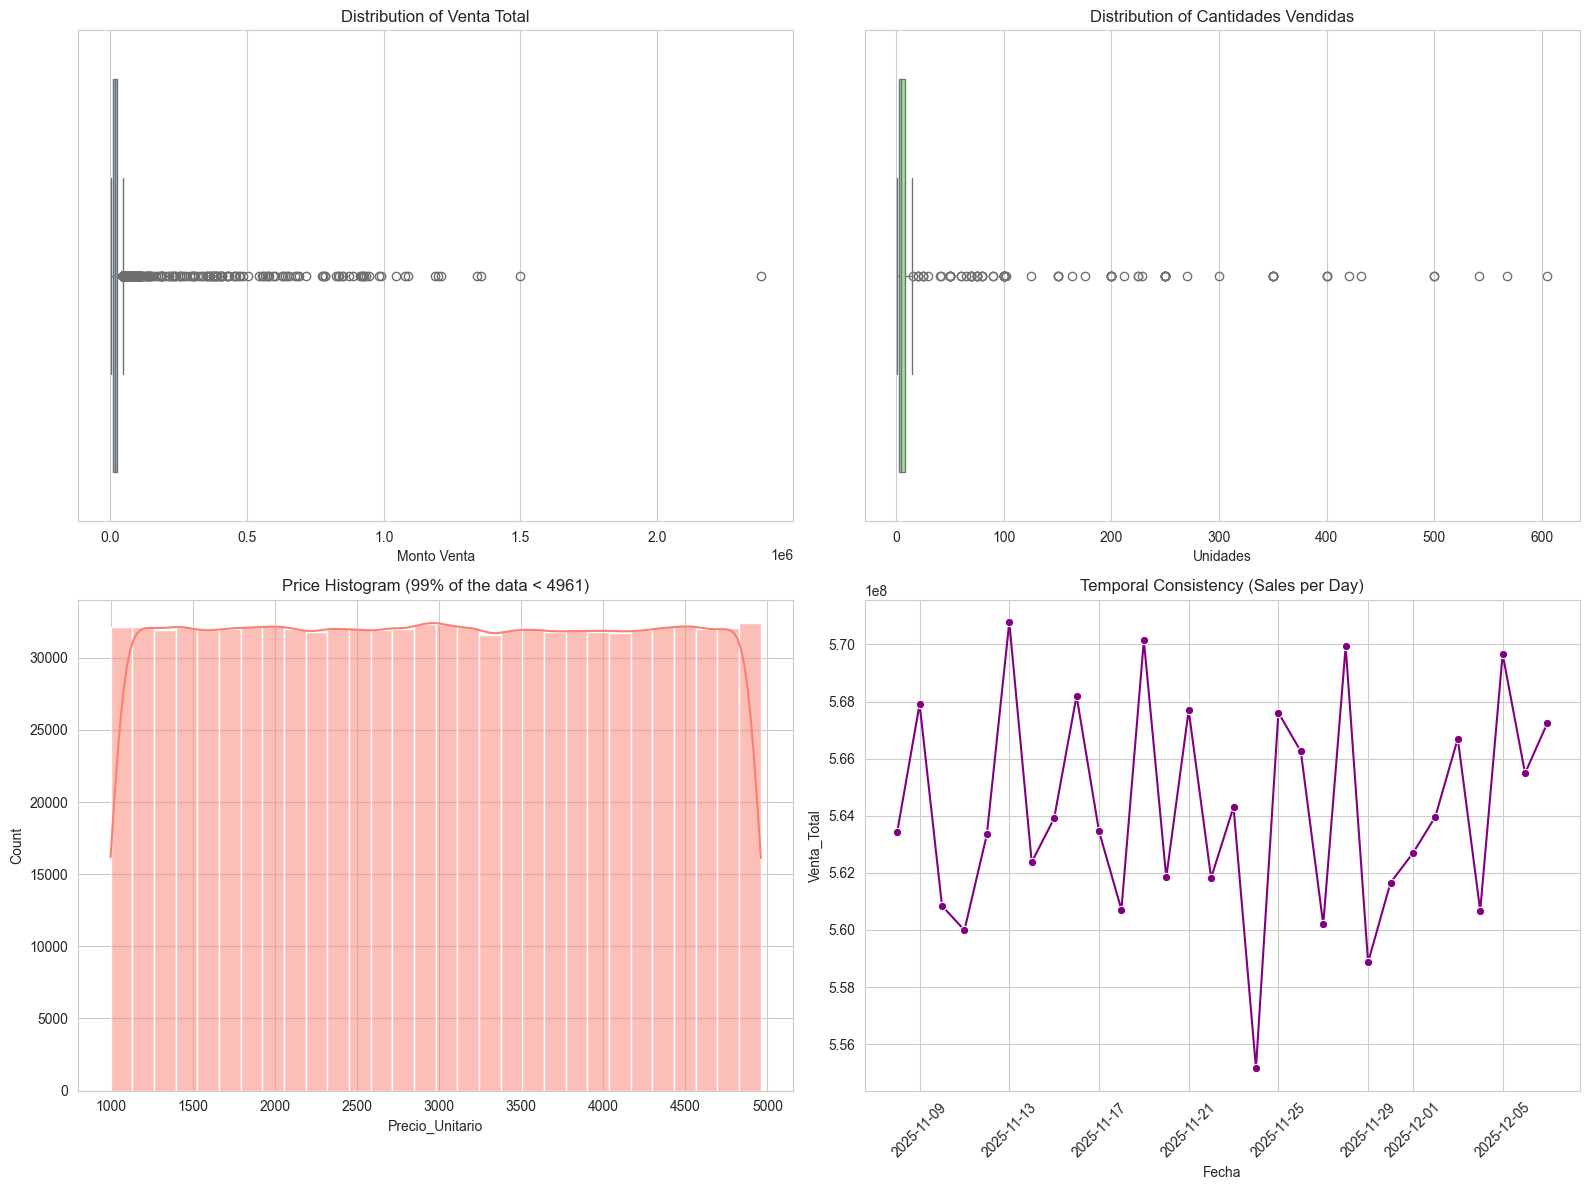

In [43]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# A)Venta Total - Box-Plot
sns.boxplot(x=df['Venta_Total'], ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution of Venta Total', fontsize=12)
axes[0, 0].set_xlabel('Monto Venta')

# B)Cantidad - Box-Plot
sns.boxplot(x=df['Cantidad'], ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Distribution of Cantidades Vendidas', fontsize=12)
axes[0, 1].set_xlabel('Unidades')

# C)Unit Price Histogram (Top 99% to ignore extremes and see the true shape)
p99 = df['Precio_Unitario'].quantile(0.99)
sns.histplot(df[df['Precio_Unitario'] < p99]['Precio_Unitario'], bins=30, kde=True, ax=axes[1, 0], color='salmon')
axes[1, 0].set_title(f'Price Histogram (99% of the data < {p99:.0f})', fontsize=12)

# D)Time Series (Daily Sales) - LOOKING FOR GAPS
daily_sales = df.groupby('Fecha')['Venta_Total'].sum().reset_index()
sns.lineplot(data=daily_sales, x='Fecha', y='Venta_Total', ax=axes[1, 1], marker='o', color='purple')
axes[1, 1].set_title('Temporal Consistency (Sales per Day)', fontsize=12)
axes[1, 1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

### IMPACT OF CLEANING (DATA SOURCE)

<Axes: ylabel='Origen_Dato'>

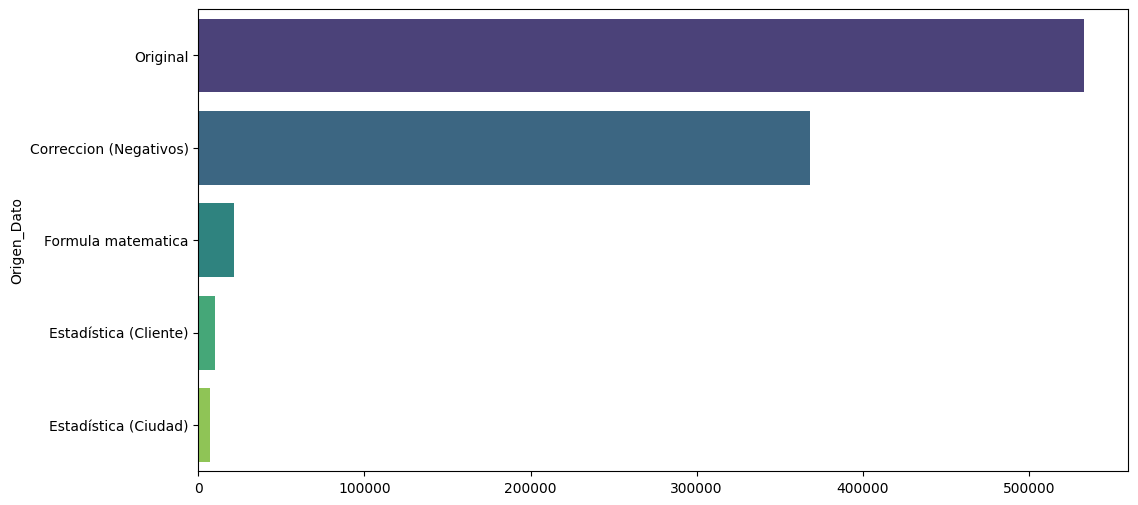

In [41]:
plt.figure(figsize=(12, 6))
top_origins = df['Origen_Dato'].value_counts().head(5)
sns.barplot(x=top_origins.values, y=top_origins.index, hue=top_origins.index, palette='viridis', 
    legend=False           
)


### MATHEMATICAL RELATIONSHIP (SCATTER PLOT)


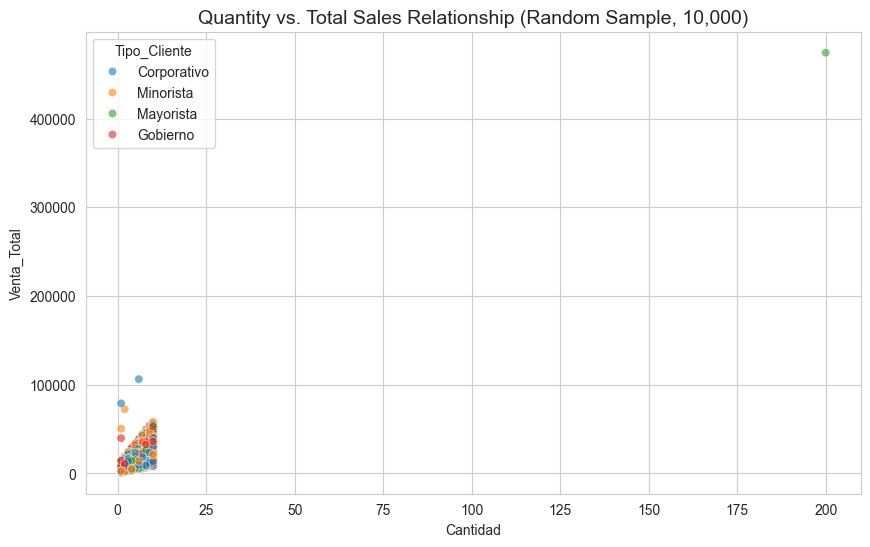

In [45]:
plt.figure(figsize=(10, 6))
sample = df.sample(min(10000, len(df))) 
sns.scatterplot(data=sample, x='Cantidad', y='Venta_Total', hue='Tipo_Cliente', alpha=0.6)
plt.title('Quantity vs. Total Sales Relationship (Random Sample, 10,000)', fontsize=14)
plt.show()

# Connection To postgresql

In [46]:
cols_prod = ['Producto', 'Tipo_Producto']
dim_producto = df[cols_prod].drop_duplicates().reset_index(drop=True)
dim_producto.index.name = 'index' 
dim_producto['id_producto'] = dim_producto.index + 1
dim_producto['sku'] = (
    dim_producto['Producto'].astype(str).str[:3].str.upper() + "-" + 
    dim_producto['Tipo_Producto'].astype(str).str[:3].str.upper() + "-" + 
    dim_producto['id_producto'].astype(str).str.zfill(3)
)
dim_producto = dim_producto[['id_producto', 'sku', 'Producto', 'Tipo_Producto']]
dim_producto.columns = ['id_producto', 'sku', 'nombre_producto', 'categoria']
print(f"Dimension Producto creada: {len(dim_producto)} items.")
dim_cliente = df[['Tipo_Cliente']].drop_duplicates().reset_index(drop=True)
dim_cliente['id_cliente'] = dim_cliente.index + 1
dim_cliente.columns = ['tipo_cliente', 'id_cliente'] 
dim_cliente = dim_cliente[['id_cliente', 'tipo_cliente']]
print(f"Dimension Cliente creada: {len(dim_cliente)} perfiles.")
dim_ubicacion = df[['Ciudad']].drop_duplicates().reset_index(drop=True)
dim_ubicacion['id_ubicacion'] = dim_ubicacion.index + 1
dim_ubicacion.columns = ['ciudad', 'id_ubicacion']
dim_ubicacion = dim_ubicacion[['id_ubicacion', 'ciudad']]
print(f"Dimension Ubicacion creada: {len(dim_ubicacion)} ciudades.")
dim_canal = df[['Tipo_Venta']].drop_duplicates().reset_index(drop=True)
dim_canal['id_canal'] = dim_canal.index + 1
dim_canal.columns = ['tipo_venta', 'id_canal']
dim_canal = dim_canal[['id_canal', 'tipo_venta']]
print(f"Dimension Canal creada: {len(dim_canal)} canales.")
print("Cruzando datos para generar Fact Table...")
df_fact = df.merge(dim_producto, left_on=['Producto', 'Tipo_Producto'], right_on=['nombre_producto', 'categoria'], how='left')
df_fact = df_fact.merge(dim_cliente, left_on='Tipo_Cliente', right_on='tipo_cliente', how='left')
df_fact = df_fact.merge(dim_ubicacion, left_on='Ciudad', right_on='ciudad', how='left')
df_fact = df_fact.merge(dim_canal, left_on='Tipo_Venta', right_on='tipo_venta', how='left')
fact_ventas = df_fact[[
    'Fecha', 
    'id_producto', 
    'id_cliente', 
    'id_ubicacion', 
    'id_canal', 
    'Cantidad', 
    'Precio_Unitario', 
    'Descuento', 
    'Costo_Envio', 
    'Venta_Total'
]].copy()
fact_ventas.columns = [
    'fecha', 'id_producto', 'id_cliente', 'id_ubicacion', 'id_canal', 
    'cantidad', 'precio_unitario', 'descuento', 'costo_envio', 'venta_total'
]
fact_ventas.reset_index(inplace=True)
fact_ventas.rename(columns={'index': 'id_venta'}, inplace=True)
fact_ventas['id_venta'] = fact_ventas['id_venta'] + 1

print(f"Fact Table lista con {len(fact_ventas)} transacciones.")

Dimension Producto creada: 8 items.
Dimension Cliente creada: 4 perfiles.
Dimension Ubicacion creada: 33 ciudades.
Dimension Canal creada: 4 canales.
Cruzando datos para generar Fact Table...
Fact Table lista con 970524 transacciones.


## Uploaded to POSTGRESQL

In [47]:
ruta_notebook = os.getcwd()
ruta_data = os.path.abspath(os.path.join(ruta_notebook, '..', 'Data'))
if not os.path.exists(ruta_data):
    os.makedirs(ruta_data)
else:
    columnas_a_borrar = ['Origen_Dato', 'origen_dato']
for col in columnas_a_borrar:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)
if 'fact_ventas' in locals():
    for col in columnas_a_borrar:
        if col in fact_ventas.columns:
            fact_ventas.drop(columns=[col], inplace=True)
            print(f"Columna '{col}' eliminada de fact_ventas.")

# Export to CSV
try:
    df.to_csv(os.path.join(ruta_data, 'RIWI_Ventas_Master_Limpia.csv'), index=False)
    print("-> RIWI_Ventas_Master_Limpia.csv OK")
    if 'dim_producto' in locals():
        dim_producto.to_csv(os.path.join(ruta_data, 'dim_producto.csv'), index=False)
        print("-> dim_producto.csv OK")
    if 'dim_cliente' in locals():
        dim_cliente.to_csv(os.path.join(ruta_data, 'dim_cliente.csv'), index=False)
        print("-> dim_cliente.csv OK")
    if 'dim_ubicacion' in locals():
        dim_ubicacion.to_csv(os.path.join(ruta_data, 'dim_ubicacion.csv'), index=False)
        print("-> dim_ubicacion.csv OK")
    if 'dim_canal' in locals():
        dim_canal.to_csv(os.path.join(ruta_data, 'dim_canal.csv'), index=False)
        print("-> dim_canal.csv OK")
    if 'fact_ventas' in locals():
        fact_ventas.to_csv(os.path.join(ruta_data, 'fact_ventas.csv'), index=False)
        print("-> fact_ventas.csv OK")
except Exception as e:
    print(f"Mistake to save: {e}")

-> RIWI_Ventas_Master_Limpia.csv OK
-> dim_producto.csv OK
-> dim_cliente.csv OK
-> dim_ubicacion.csv OK
-> dim_canal.csv OK
-> fact_ventas.csv OK


In [48]:
ruta_notebook = os.getcwd()
ruta_raiz = os.path.abspath(os.path.join(ruta_notebook, '..'))
if ruta_raiz not in sys.path:
    sys.path.append(ruta_raiz)
from db_connect import get_db_engine
engine = get_db_engine()
if engine:
    try:
        with engine.connect() as conn:
            conn.execute(text("TRUNCATE TABLE fact_ventas, dim_producto, dim_cliente, dim_ubicacion, dim_canal RESTART IDENTITY CASCADE;"))
            conn.commit()
        def cargar_tabla(df, nombre_sql):
            if df is not None and not df.empty:
                print(f"Subiendo '{nombre_sql}' ({len(df)} filas)...")
                df.to_sql(
                    nombre_sql, 
                    engine, 
                    if_exists='append', 
                    index=False, 
                    method='multi', 
                    chunksize=2000
                )
                print(f"'{nombre_sql}' completed.")
            else:
                print(f"'{nombre_sql}' (DataFrame empty o don't exist).")
        # Uploated Dimensiones
        if 'dim_producto' in locals(): cargar_tabla(dim_producto, 'dim_producto')
        if 'dim_cliente' in locals():  cargar_tabla(dim_cliente, 'dim_cliente')
        if 'dim_ubicacion' in locals(): cargar_tabla(dim_ubicacion, 'dim_ubicacion')
        if 'dim_canal' in locals():    cargar_tabla(dim_canal, 'dim_canal')

        if 'fact_ventas' in locals():
            print(f"Uploed.. 'fact_ventas' ")
            fact_ventas.to_sql('fact_ventas', engine, if_exists='append', index=False, chunksize=5000)
            print(f"¡FACT_VENTAS Uploated! ({len(fact_ventas)} records)")
    except Exception as e:
        print(f"\nBig mistake: {e}")
else:
    print("Can't connect with database. Check '.env' or 'db_connect.py'")

Subiendo 'dim_producto' (8 filas)...
'dim_producto' completed.
Subiendo 'dim_cliente' (4 filas)...
'dim_cliente' completed.
Subiendo 'dim_ubicacion' (33 filas)...
'dim_ubicacion' completed.
Subiendo 'dim_canal' (4 filas)...
'dim_canal' completed.
Uploed.. 'fact_ventas' 
¡FACT_VENTAS Uploated! (970524 records)
